In [2]:
# Prediction of molecular properties using GCN
import os
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import *
import networkx as nx # 그래프 데이터 만들어주는 라이브러리
from stl import mesh
import trimesh
from scipy.linalg import fractional_matrix_power
from sklearn.metrics import r2_score

import spektral #GNN 라이브러리 

os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline

In [3]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 10000)
list_feature, list_adj = convert_to_graph(list_smi)
list_feature, list_adj  = np.asarray(list_feature),np.asarray(list_adj)

Reading Data:   0%|          | 0/10000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
N, F = list_feature[0].shape

In [6]:
all_idx = np.arange(10000)
np.random.shuffle(all_idx)
train_idx = all_idx[:9000]
val_idx = all_idx[9000:]

In [100]:
def readout_nw(H, output_dim):
    # _X : final node embeddings
    output = tf.keras.layers.Dense(output_dim)(H)
    output = tf.reduce_sum(output, axis=1)
    output = tf.keras.activations.relu(output)   
    return output

def build_model_library(unit1,unit2,lr=1e-2,loss='mse'): #library version
                
    H_in = tf.keras.layers.Input(shape=(N,F,))
    A_in = tf.keras.layers.Input(shape=(N,N,))

    graph_conv_1 = spektral.layers.GCNConv(channels = 32,
                                             activation = 'relu')([H_in, A_in])

    graph_conv_2 = spektral.layers.GCNConv(channels = 32,
                                             activation = 'relu')([graph_conv_1, A_in])
    
    graph_conv_3 = spektral.layers.GCNConv(channels = 32,
                                             activation = 'relu')([graph_conv_2, A_in])
    
    graph_feature = readout_nw(graph_conv_3, 128)
    
    out = tf.keras.layers.Flatten()(graph_feature)
    out = tf.keras.layers.Dense(unit1,'relu')(out)
    out = tf.keras.layers.Dense(unit2,'relu')(out)
    out = tf.keras.layers.Dense(1,'linear')(out)
    model = tf.keras.models.Model(inputs = [H_in, A_in], outputs = out)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = loss)

    return model

# "Deeply learning molecular structure-property relationships using attention- and gate-augmented graph convolutional network"
# source_code --> https://github.com/SeongokRyu/Graph-neural-networks/blob/master/tutorials/gcn_prediction.ipynb
# paper --> https://arxiv.org/abs/1805.10988 

def graph_conv(H, A, ch):
    output = tf.keras.layers.Dense(ch)(H)
    output = tf.matmul(A, output)
    output = tf.keras.activations.relu(output)
    return output

def build_model_custom(unit1,unit2,lr=1e-2,loss='mse'): #custom version
                
    H_in = tf.keras.layers.Input(shape=(N,F,))
    A_in = tf.keras.layers.Input(shape=(N,N,))

    gconv1 = graph_conv(H_in, A_in, 32)
    gconv2 = graph_conv(gconv1, A_in, 32)
    gconv3 = graph_conv(gconv2, A_in, 32)
    graph_feature = readout_nw(gconv3, 128)

    out = tf.keras.layers.Dense(unit1,'relu')(graph_feature)
    out = tf.keras.layers.Dense(unit2,'relu')(out)
    out = tf.keras.layers.Dense(1,'linear')(out)
    model = tf.keras.models.Model(inputs = [H_in, A_in], outputs = out)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = loss)

    return model

In [135]:
SaveName = 'molecular'
model = build_model_library(100,50,lr=1e-3,loss='mse')

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=50,monitor='val_loss'),
                tf.keras.callbacks.ModelCheckpoint(filepath='./models/{}.tf'.format(SaveName)
                                                   ,save_best_only=True)]

hist = model.fit([list_feature[train_idx], list_adj[train_idx]], list_logP[train_idx],
                 validation_data=([list_feature[val_idx], list_adj[val_idx]], list_logP[val_idx]),
                 epochs = 500,
                 batch_size = 16,verbose=0,callbacks=[my_callbacks])

df = pd.DataFrame(hist.history)
df.to_csv('{}.csv'.format(SaveName),index=False)

INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular.tf/assets
INFO:tensorflow:Assets written to: ./mod

In [136]:
SaveName = 'molecular_custom'
model =  build_model_custom(100,50,lr=1e-3,loss='mse')

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=50,monitor='val_loss'),
                tf.keras.callbacks.ModelCheckpoint(filepath='./models/{}.tf'.format(SaveName)
                                                   ,save_best_only=True)]

hist = model.fit([list_feature[train_idx], list_adj[train_idx]], list_logP[train_idx],
                 validation_data=([list_feature[val_idx], list_adj[val_idx]], list_logP[val_idx]),
                 epochs = 500,
                 batch_size = 16,verbose=0,callbacks=[my_callbacks])

df = pd.DataFrame(hist.history)
df.to_csv('{}.csv'.format(SaveName),index=False)

INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:tensorflow:Assets written to: ./models/molecular_custom.tf/assets
INFO:t

In [137]:
def result_show(SaveName):
    history = pd.read_csv('{}.csv'.format(SaveName))
    model = tf.keras.models.load_model('./models/{}.tf'.format(SaveName))
    val_inp, val_true = [list_feature[val_idx], list_adj[val_idx]], list_logP[val_idx]
    val_pred = model(val_inp).numpy().flatten()

    plt.figure(figsize=(10,3))
    plt.suptitle(SaveName)
    plt.subplot(1,3,1)
    plt.title('train_curve')
    plt.plot(hist.history['loss'],label='train')
    plt.plot(hist.history['val_loss'],label='val')

    plt.subplot(1,3,2)
    plt.title('logP prediction')
    plt.plot(val_true,val_true)
    plt.scatter(val_true,val_pred,color='green',marker='.',label='R score:{}'.format(r2_score(val_true, val_pred).round(3)))
    plt.legend()
    plt.tight_layout()

    plt.subplot(1,3,3)
    plt.title('error distribution(mape)')
    mape_arr = [tf.keras.losses.mape(true.reshape(-1,1), pred.reshape(-1,1)).numpy()[0] for true, pred in zip(val_true, val_pred)]
    plt.hist(mape_arr,bins=100,label = "mean error: %.2f" %np.median(mape_arr)+'%')
    plt.legend()
    plt.tight_layout()
    plt.show()

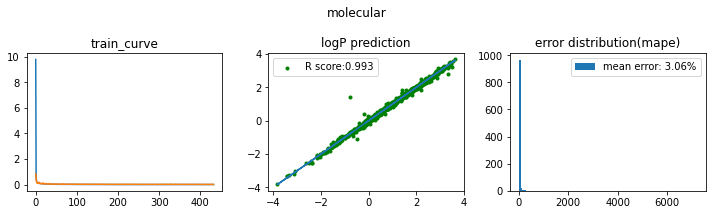

In [138]:
result_show(SaveName='molecular')

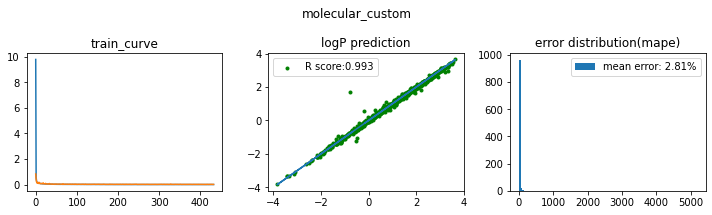

In [139]:
result_show(SaveName='molecular_custom')